In [ ]:
!pip3 install -q transformers==3.0.2
!pip3 install -q simpletransformers==0.48.0

from __future__ import absolute_import, division, print_function

#Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

#PDF/Excel IO
import os
from pandas import ExcelWriter
from pandas import ExcelFile
import pickle

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

#Text Mining Packages
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import nltk
nltk.download('stopwords')

#Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

from __future__ import absolute_import, division, print_function

#Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

#PDF/Excel IO
import fileinput
import glob
import os
from pandas import ExcelWriter
from pandas import ExcelFile

#Text Mining Packages
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import sklearn

#Deep Learning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from scipy.special import softmax

#Bert
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm_notebook, trange
import transformers
from multiprocessing import Pool, cpu_count
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
import logging
import random
import json
from torch.utils.data.distributed import DistributedSampler
import simpletransformers
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import MultiLabelClassificationModel
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

clear_output(wait=True)
print("All packages imported successfully!")

All packages imported successfully!


In [ ]:
%%writefile setup.sh
git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir ./

Writing setup.sh


In [ ]:
!sh setup.sh
from apex import amp
clear_output(wait=True)
print("Cuda available: ", torch.cuda.is_available())

Cuda available:  True


In [ ]:
#Read dataset

tranformers_dataset = pd.read_csv('transformer_dataset.csv')
tranformers_dataset = tranformers_dataset.rename(columns={"Unnamed: 0": "key"})
tranformers_dataset

,key,text,innovation
0,0,home imda imda matrijzenmakerij matrijzenmaker...,1
1,1,home values kwaliteit veiligheid stiptheid lea...,1
2,2,orfit industries leader thermoplastic innovati...,1
3,3,home producten galerij nieuws vacatures contac...,0
4,4,bestellen home varkensprijzen kwaliteit histor...,1
...,...,...,...
2663,2663,menu home producten referenties documentatie d...,1
2664,2664,home oplossingen zelfstandig bed bad toilet be...,1
2665,2665,javascript lijkt uitgeschakeld browser beste g...,1
2666,2666,home home verhaal producten bouwstaalmatten ma...,0


In [ ]:
def oversample_category(dataset, innovation_category, total_size, seed_value):
    dataset = dataset.reset_index()
    index_list = list(dataset[dataset['innovation'] == innovation_category].index)
    np.random.seed(seed_value)
    choices = np.random.choice(index_list, size=total_size-len(index_list), replace=True)
    key = []
    text = []
    innovation = []
    for i in choices:
        key.append(dataset.iloc[i]['key'])
        text.append(dataset.iloc[i]['text'])
        innovation.append(dataset.iloc[i]['innovation'])
    df = pd.DataFrame({'key': key,'text': text,'innovation': innovation})
    temp_df = pd.concat([dataset, df])
    return temp_df.reset_index()

def transformer_sets(dataset, seed, fraction, oversample = False, size = 0):
    if (oversample):
        temp_df = oversample_category(dataset, 0, size, 22494)
    temp_df = temp_df.fillna(0)
    train_temp = temp_df.sample(frac = fraction, random_state = seed)
    test_temp = temp_df.drop(train_temp.index)
    test_temp = test_temp.drop_duplicates(['key'])
    return train_temp[['text','innovation']], test_temp[['text','innovation']]

In [ ]:
train_set, test_set = transformer_sets(tranformers_dataset, 22494, 0.8, True, 1650)
train_set = train_set.rename(columns={"innovation": "labels"})
test_set = test_set.rename(columns={"innovation": "labels"})

In [ ]:
#Clear cache before each run to empty RAM and Disk
import gc
import shutil

torch.cuda.empty_cache()
gc.collect()
try:
  shutil.rmtree('outputs')  
  shutil.rmtree('runs')
except:
  pass 

#Parameters to train
train_args = {
    'max_seq_length': 64,
    'num_train_epochs': 12,
    'train_batch_size': 32,
    'eval_batch_size': 32,
    'learning_rate': 2e-5,
    'adam_epsilon': 1e-6,
    'warmup_ratio': 0.06,
    'warmup_steps': 0,
    'eval_all_checkpoints': False,
    'no_cache': True,
    'reprocess_input_data': True,
    'evaluate_during_training': False,
    'output_dir': 'outputs/',
    'overwrite_output_dir': True,
    'save_model_every_epoch': False
}

model = ClassificationModel('bert', 'bert-base-multilingual-uncased', args=train_args, use_cuda=True)
model.train_model(train_set)
result, model_outputs, wrong_predictions = model.eval_model(test_set)
predictions, raw_outputs = model.predict(test_set['text'].tolist())

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /root/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.fcb1786f49c279f0e0f158c9972b9bd9f6c0edb5d893dcb9b530d714d86f0edc
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_tra

  0%|          | 0/2992 [00:00<?, ?it/s]

Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 0 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 1 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 2 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 3 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 4 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 5 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 6 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 7 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 8 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 9 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 10 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 11 of 12:   0%|          | 0/94 [00:00<?, ?it/s]

INFO:transformers.configuration_utils:Configuration saved in outputs/config.json
INFO:transformers.modeling_utils:Model weights saved in outputs/pytorch_model.bin
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


  0%|          | 0/682 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.7540387763111219, 'tp': 357, 'tn': 241, 'fp': 20, 'fn': 64, 'eval_loss': 0.5089031287722967}
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


  0%|          | 0/682 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
#bert-base
#bert-base-multilingual-uncased
#wietsedv/bert-base-dutch-cased
#roberta-base
#pdelobelle/robbert-v2-dutch-base

In [ ]:
#Classification Report

true = test_set['labels'].tolist()
mat = sklearn.metrics.classification_report(true , predictions, target_names=['Not innovaive', 'Innovative'])
print(result, '\n')
print(mat)
print('\nTest Set Accuracy: ', accuracy_score(true,predictions), '\n')

{'mcc': 0.7652427755880014, 'tp': 360, 'tn': 242, 'fp': 19, 'fn': 61, 'eval_loss': 0.5040269402617757} 

               precision    recall  f1-score   support

Not innovaive       0.80      0.93      0.86       261
   Innovative       0.95      0.86      0.90       421

     accuracy                           0.88       682
    macro avg       0.87      0.89      0.88       682
 weighted avg       0.89      0.88      0.88       682


Test Set Accuracy:  0.8826979472140762 



In [ ]:
#Classification Report

true = test_set['labels'].tolist()
mat = sklearn.metrics.classification_report(true , predictions, target_names=['Not innovaive', 'Innovative'])
print(result, '\n')
print(mat)
print('\nTest Set Accuracy: ', accuracy_score(true,predictions), '\n')

{'mcc': 0.8378497661568364, 'tp': 48, 'tn': 75, 'fp': 1, 'fn': 10, 'eval_loss': 0.46740045210462994} 

               precision    recall  f1-score   support

Not innovaive       0.88      0.99      0.93        76
   Innovative       0.98      0.83      0.90        58

     accuracy                           0.92       134
    macro avg       0.93      0.91      0.91       134
 weighted avg       0.92      0.92      0.92       134


Test Set Accuracy:  0.917910447761194 



In [ ]:
#Classification Report

true = test_set['labels'].tolist()
mat = sklearn.metrics.classification_report(true , predictions, target_names=['Not innovaive', 'Innovative'])
print(result, '\n')
print(mat)
print('\nTest Set Accuracy: ', accuracy_score(true,predictions), '\n')

{'mcc': 0.7790245728533609, 'tp': 379, 'tn': 231, 'fp': 30, 'fn': 42, 'eval_loss': 0.4010269512126053} 

               precision    recall  f1-score   support

Not innovaive       0.85      0.89      0.87       261
   Innovative       0.93      0.90      0.91       421

     accuracy                           0.89       682
    macro avg       0.89      0.89      0.89       682
 weighted avg       0.90      0.89      0.89       682


Test Set Accuracy:  0.8944281524926686 



INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


{'mcc': 0.81638957229497, 'tp': 364, 'tn': 278, 'fp': 10, 'fn': 57, 'eval_loss': 0.5233768629429475} 

               precision    recall  f1-score   support

Not innovaive       0.83      0.97      0.89       288
   Innovative       0.97      0.86      0.92       421

     accuracy                           0.91       709
    macro avg       0.90      0.91      0.90       709
 weighted avg       0.92      0.91      0.91       709


Test Set Accuracy:  0.9055007052186178 



  0%|          | 0/3272 [00:00<?, ?it/s]

  0%|          | 0/409 [00:00<?, ?it/s]

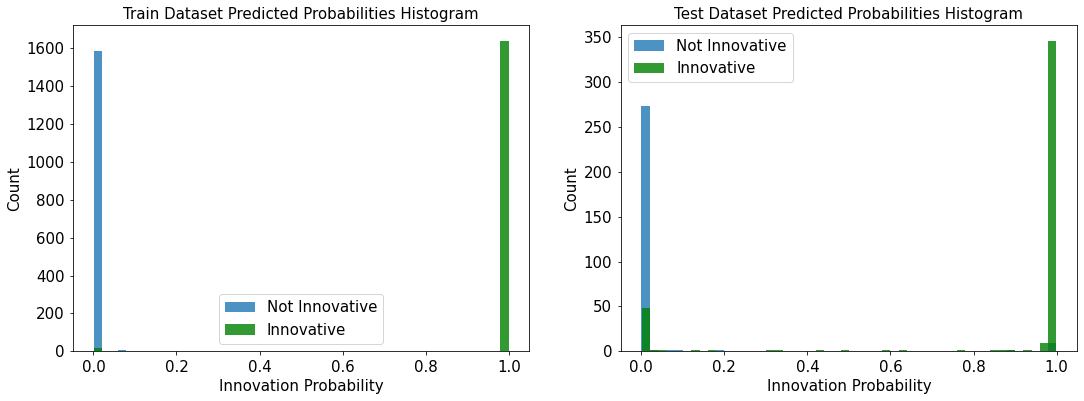

In [ ]:
#Classification Report

true = test_set['labels'].tolist()
mat = sklearn.metrics.classification_report(true , predictions, target_names=['Not innovaive', 'Innovative'])
print(result, '\n')
print(mat)
print('\nTest Set Accuracy: ', accuracy_score(true,predictions), '\n')

In [ ]:
#Best Params So Far
train_args = {
    'max_seq_length': 64,
    'num_train_epochs': 5,
    'train_batch_size': 4,
    'eval_batch_size': 4,
    'learning_rate': 2e-5,
    'adam_epsilon': 1e-6,
    'warmup_ratio': 0.06,
    'warmup_steps': 0,
    'eval_all_checkpoints': False,
    'no_cache': True,
    'reprocess_input_data': True,
    'evaluate_during_training': False,
    'output_dir': 'outputs/',
    'overwrite_output_dir': True,
    'save_model_every_epoch': False


model = ClassificationModel('bert', 'bert-base-uncased', args=train_args, use_cuda=True)
model.train_model(train_set)
result, model_outputs, wrong_predictions = model.eval_model(test_set)
predictions, raw_outputs = model.predict(test_set['text'].tolist())

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


{'mcc': 0.808683871415563, 'tp': 370, 'tn': 271, 'fp': 17, 'fn': 51, 'eval_loss': 0.5760510610027391} 

               precision    recall  f1-score   support

Not innovaive       0.84      0.94      0.89       288
   Innovative       0.96      0.88      0.92       421

     accuracy                           0.90       709
    macro avg       0.90      0.91      0.90       709
 weighted avg       0.91      0.90      0.90       709


Test Set Accuracy:  0.9040902679830748 



  0%|          | 0/3272 [00:00<?, ?it/s]

  0%|          | 0/818 [00:00<?, ?it/s]

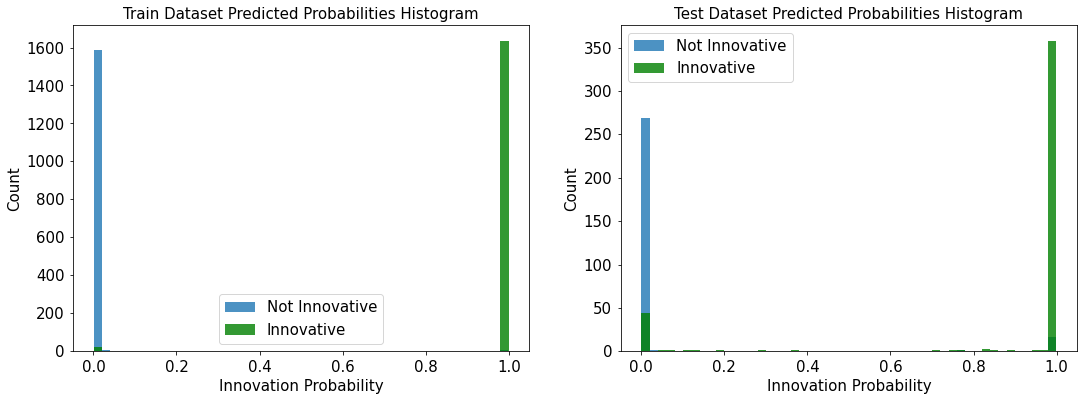

In [ ]:
#Classification Report

true = test_set['labels'].tolist()
mat = sklearn.metrics.classification_report(true , predictions, target_names=['Not innovaive', 'Innovative'])
print(result, '\n')
print(mat)
print('\nTest Set Accuracy: ', accuracy_score(true,predictions), '\n')

#Plot the predicted probabilities from the model - Test Set

predictions_train, raw_outputs_train = model.predict(train_set['text'].tolist())
train_pred  = softmax(raw_outputs_train, axis=1)[:,1]
test_pred  = softmax(raw_outputs, axis=1)[:,1]

fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_set['labels']==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_set['labels']==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_set['labels']==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_set['labels']==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 